# Goal

In this notebook, we will process the cellranger outputs for our 648 condition combinatorial signal-seq screen in CD4 T cells. We will generate the following files:

**SIG13_unfiltered.h5mu**: MuData object containing raw and DSB normalized barcode counts and raw gene expression counts. No filtering performed.

**SIG13_filtered.h5ad**: AnnData object containing raw and normalized gene expression data for cells that passed RNA QC and were correctly called as having two ligand VLPs delivered.

# Import

Here, we will import required packages, filtered cellranger data, and raw cellranger data for the barcodes (necessary for DSB normalization). Custom functions used in these notebooks can be found in the functions folder of the repository.

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import muon as mu
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set scanpy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
import IPython.display
from matplotlib_inline.backend_inline import set_matplotlib_formats
IPython.display.set_matplotlib_formats = set_matplotlib_formats
sc.settings.set_figure_params(dpi=80, facecolor="white")

# import custom functions
import sys
sys.path.insert(0, '/data1/rudenska/EYW/git_projects/SIG13/functions')
import scanpy_custom as scc

/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


In [43]:
# concatenate anndata across lanes
import os
lane_dir_pattern = "/data1/rudenska/EYW/SIG13/SIG13_lane{}/SIG13_lane{}_GEX_oBC"
rna_list = []
bc_list = []
for i in [1,2]:
    # Build the file path for lane i and read the 10x h5 file
    lane_dir = lane_dir_pattern.format(i,i)
    h5_path_rep1 = os.path.join(lane_dir, "outs","per_sample_outs","SIG13_rep1","count", "sample_filtered_feature_bc_matrix.h5")
    h5_path_rep2 = os.path.join(lane_dir, "outs","per_sample_outs","SIG13_rep2","count", "sample_filtered_feature_bc_matrix.h5")
    
    #  import rep1 and rep2 data
    mdata_rep1 = mu.read_10x_h5(h5_path_rep1)
    mdata_rep1.var_names_make_unique()
    mdata_rep2 = mu.read_10x_h5(h5_path_rep2)
    mdata_rep2.var_names_make_unique()
    
    # create linked anndata objects
    rna_1 = mdata_rep1.mod['rna']
    rna_1.obs['replicate'] = 'rep1'
    bc_1 = mdata_rep1.mod['CRISPR Guide Capture']
    rna_2 = mdata_rep2.mod['rna']
    rna_2.obs['replicate'] = 'rep2'
    bc_2 = mdata_rep2.mod['CRISPR Guide Capture']

    # merge anndata from different replicates
    rna_temp = ad.concat([rna_1, rna_2], axis=0)
    bc_temp = ad.concat([bc_1, bc_2], axis=0)
    
    # Rename barcodes: add -i to the existing barcode name
    rna_temp.obs_names = [cell_bc.rsplit('-', 1)[0] + f"-{i}" for cell_bc in rna_temp.obs_names]
    bc_temp.obs_names = [cell_bc.rsplit('-', 1)[0] + f"-{i}" for cell_bc in bc_temp.obs_names]

    # Append modalities to lsits
    rna_list.append(rna_temp)
    bc_list.append(bc_temp)

# Merge all lane data into one AnnData object
rna = ad.concat(rna_list, axis=0, join="outer", merge="unique")
bc = ad.concat(bc_list, axis=0, join="outer", merge="unique")

# make concatenated mudata object
mdata = mu.MuData({"rna": rna, "bc": bc})
mdata.pull_obs()

reading /data1/rudenska/EYW/SIG13/SIG13_lane1/SIG13_lane1_GEX_oBC/outs/per_sample_outs/SIG13_rep1/count/sample_filtered_feature_bc_matrix.h5
 (0:00:10)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /data1/rudenska/EYW/SIG13/SIG13_lane1/SIG13_lane1_GEX_oBC/outs/per_sample_outs/SIG13_rep2/count/sample_filtered_feature_bc_matrix.h5


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:947: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs

 (0:00:14)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

reading /data1/rudenska/EYW/SIG13/SIG13_lane2/SIG13_lane2_GEX_oBC/outs/per_sample_outs/SIG13_rep1/count/sample_filtered_feature_bc_matrix.h5
 (0:00:10)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /data1/rudenska/EYW/SIG13/SIG13_lane2/SIG13_lane2_GEX_oBC/outs/per_sample_outs/SIG13_rep2/count/sample_filtered_feature_bc_matrix.h5


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:947: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs

 (0:00:14)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

In [44]:
# concatenate anndata across lanes
import os
lane_dir_pattern = "/data1/rudenska/EYW/SIG13/SIG13_lane{}/SIG13_lane{}_GEX_oBC"
bc_list = []
for i in [1,2]:
    # Build the file path for lane i and read the 10x h5 file
    lane_dir = lane_dir_pattern.format(i,i)
    h5_path_rep1 = os.path.join(lane_dir, "outs","per_sample_outs","SIG13_rep1","count", "sample_raw_feature_bc_matrix.h5")
    h5_path_rep2 = os.path.join(lane_dir, "outs","per_sample_outs","SIG13_rep2","count", "sample_raw_feature_bc_matrix.h5")
    
    #  import rep1 and rep2 data
    mdata_rep1 = mu.read_10x_h5(h5_path_rep1)
    mdata_rep1.var_names_make_unique()
    mdata_rep2 = mu.read_10x_h5(h5_path_rep2)
    mdata_rep2.var_names_make_unique()
    
    # create linked anndata objects
    bc_1 = mdata_rep1.mod['CRISPR Guide Capture']
    bc_2 = mdata_rep2.mod['CRISPR Guide Capture']

    # merge anndata from different replicates
    bc_temp = ad.concat([bc_1, bc_2], axis=0)
    
    # Rename barcodes: add -i to the existing barcode name
    bc_temp.obs_names = [cell_bc.rsplit('-', 1)[0] + f"-{i}" for cell_bc in bc_temp.obs_names]

    # Append modalities to lsits
    bc_list.append(bc_temp)

# Merge all lane data into one AnnData object
bc_raw = ad.concat(bc_list, axis=0, join="outer", merge="unique")

reading /data1/rudenska/EYW/SIG13/SIG13_lane1/SIG13_lane1_GEX_oBC/outs/per_sample_outs/SIG13_rep1/count/sample_raw_feature_bc_matrix.h5
 (0:00:14)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

reading /data1/rudenska/EYW/SIG13/SIG13_lane1/SIG13_lane1_GEX_oBC/outs/per_sample_outs/SIG13_rep2/count/sample_raw_feature_bc_matrix.h5
 (0:00:18)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

reading /data1/rudenska/EYW/SIG13/SIG13_lane2/SIG13_lane2_GEX_oBC/outs/per_sample_outs/SIG13_rep1/count/sample_raw_feature_bc_matrix.h5
 (0:00:13)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

reading /data1/rudenska/EYW/SIG13/SIG13_lane2/SIG13_lane2_GEX_oBC/outs/per_sample_outs/SIG13_rep2/count/sample_raw_feature_bc_matrix.h5
 (0:00:18)


/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-pac

In [45]:
# make lane metadata
cell_bcs = pd.DataFrame({'cell_id': mdata.obs.index})
cell_bcs = cell_bcs['cell_id'].str.split('-', expand=True)
cell_bcs.columns = ['barcode', 'lane']
cell_bcs.index = mdata.obs.index

In [46]:
# add lane metadata
mdata.obs['lane'] = cell_bcs['lane'] # add lane to obs
mdata.push_obs()
mdata

MuData object with n_obs × n_vars = 628715 × 19144
  obs:	'lane'
  2 modalities
    rna:	628715 x 19070
      obs:	'replicate', 'lane'
    bc:	628715 x 74
      obs:	'lane'

# BC DSB Normalization

Here, we will perform DSB normalization on the barcode counts using raw and filtered cellranger outputs. Here, we are using a custom parallelized version of dsb normalization rather than the muon implementation.

In [47]:
%%time
# run DSB (SAIL version)
bc.layers['counts'] = bc.X.copy()
scc.dsb_normalize_adata(adata_filtered=bc, adata_raw=bc_raw)

Fitting Gaussian Mixture Models (parallelized)...


GMM per cell: 100%|██████████| 628715/628715 [01:25<00:00, 7340.89it/s]


CPU times: user 16.2 s, sys: 5.05 s, total: 21.2 s
Wall time: 1min 34s


/tmp/ipykernel_478848/267620174.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=bc_df_melt, x='Feature', y='UMI_count', inner='quartile', scale='width')


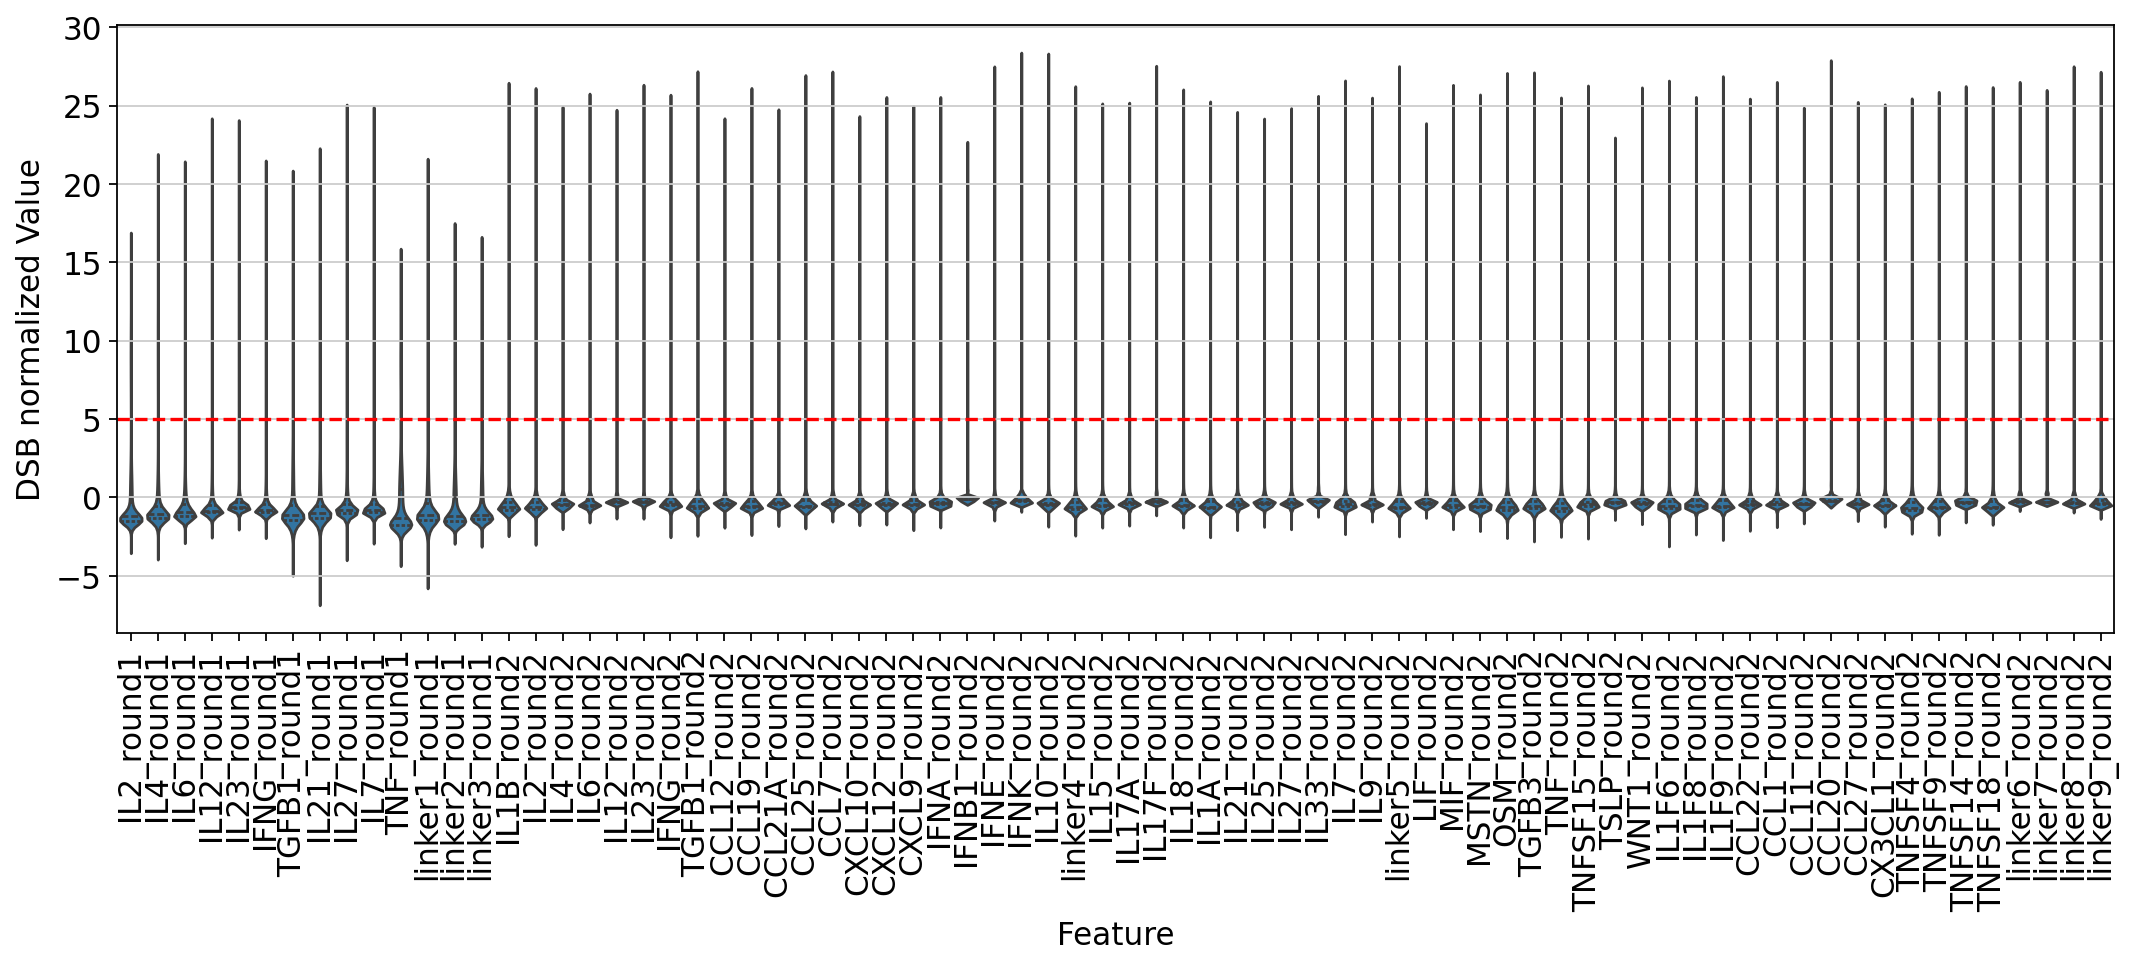

In [48]:
# Convert the UMI counts for all features to a DataFrame (no log transform)
bc_df = pd.DataFrame(bc.layers['dsb'], columns=bc.var_names, index=bc.obs_names)

# Melt for seaborn violinplot
bc_df_melt = bc_df.melt(var_name='Feature', value_name='UMI_count')

plt.figure(figsize=(16, 5))
sns.violinplot(data=bc_df_melt, x='Feature', y='UMI_count', inner='quartile', scale='width')

# add horizontal red line at y=5
plt.axhline(y=5, color='red', linestyle='--')

plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('DSB normalized Value')
plt.show()

# Export Unfiltered Data

In [ ]:
mdata.write("/data1/rudenska/EYW/SIG13/scanpy_outs/SIG13_unfiltered.h5mu")

/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


# RNA QC
Here we will perform QC on rna: filtering based on mitochondrial percentage, number of genes detected, and total counts.

In [50]:
# define mitochondrial genes
rna.var["mt"] = rna.var_names.str.startswith("mt-")
# define ribosomal genes
rna.var["ribo"] = rna.var_names.str.startswith(("Rps", "Rpl"))
# calculate qc metrics
sc.pp.calculate_qc_metrics(rna, qc_vars=["mt", "ribo"], inplace=True, log1p=True)
# calculate gene saturation
rna.obs['log10_genes_per_umi'] = np.log10(rna.obs['n_genes_by_counts']) / np.log10(rna.obs['total_counts'])

## Plot QC Values

/data1/rudenska/EYW/git_projects/SIG13/functions/scanpy_custom/plotting.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.93])


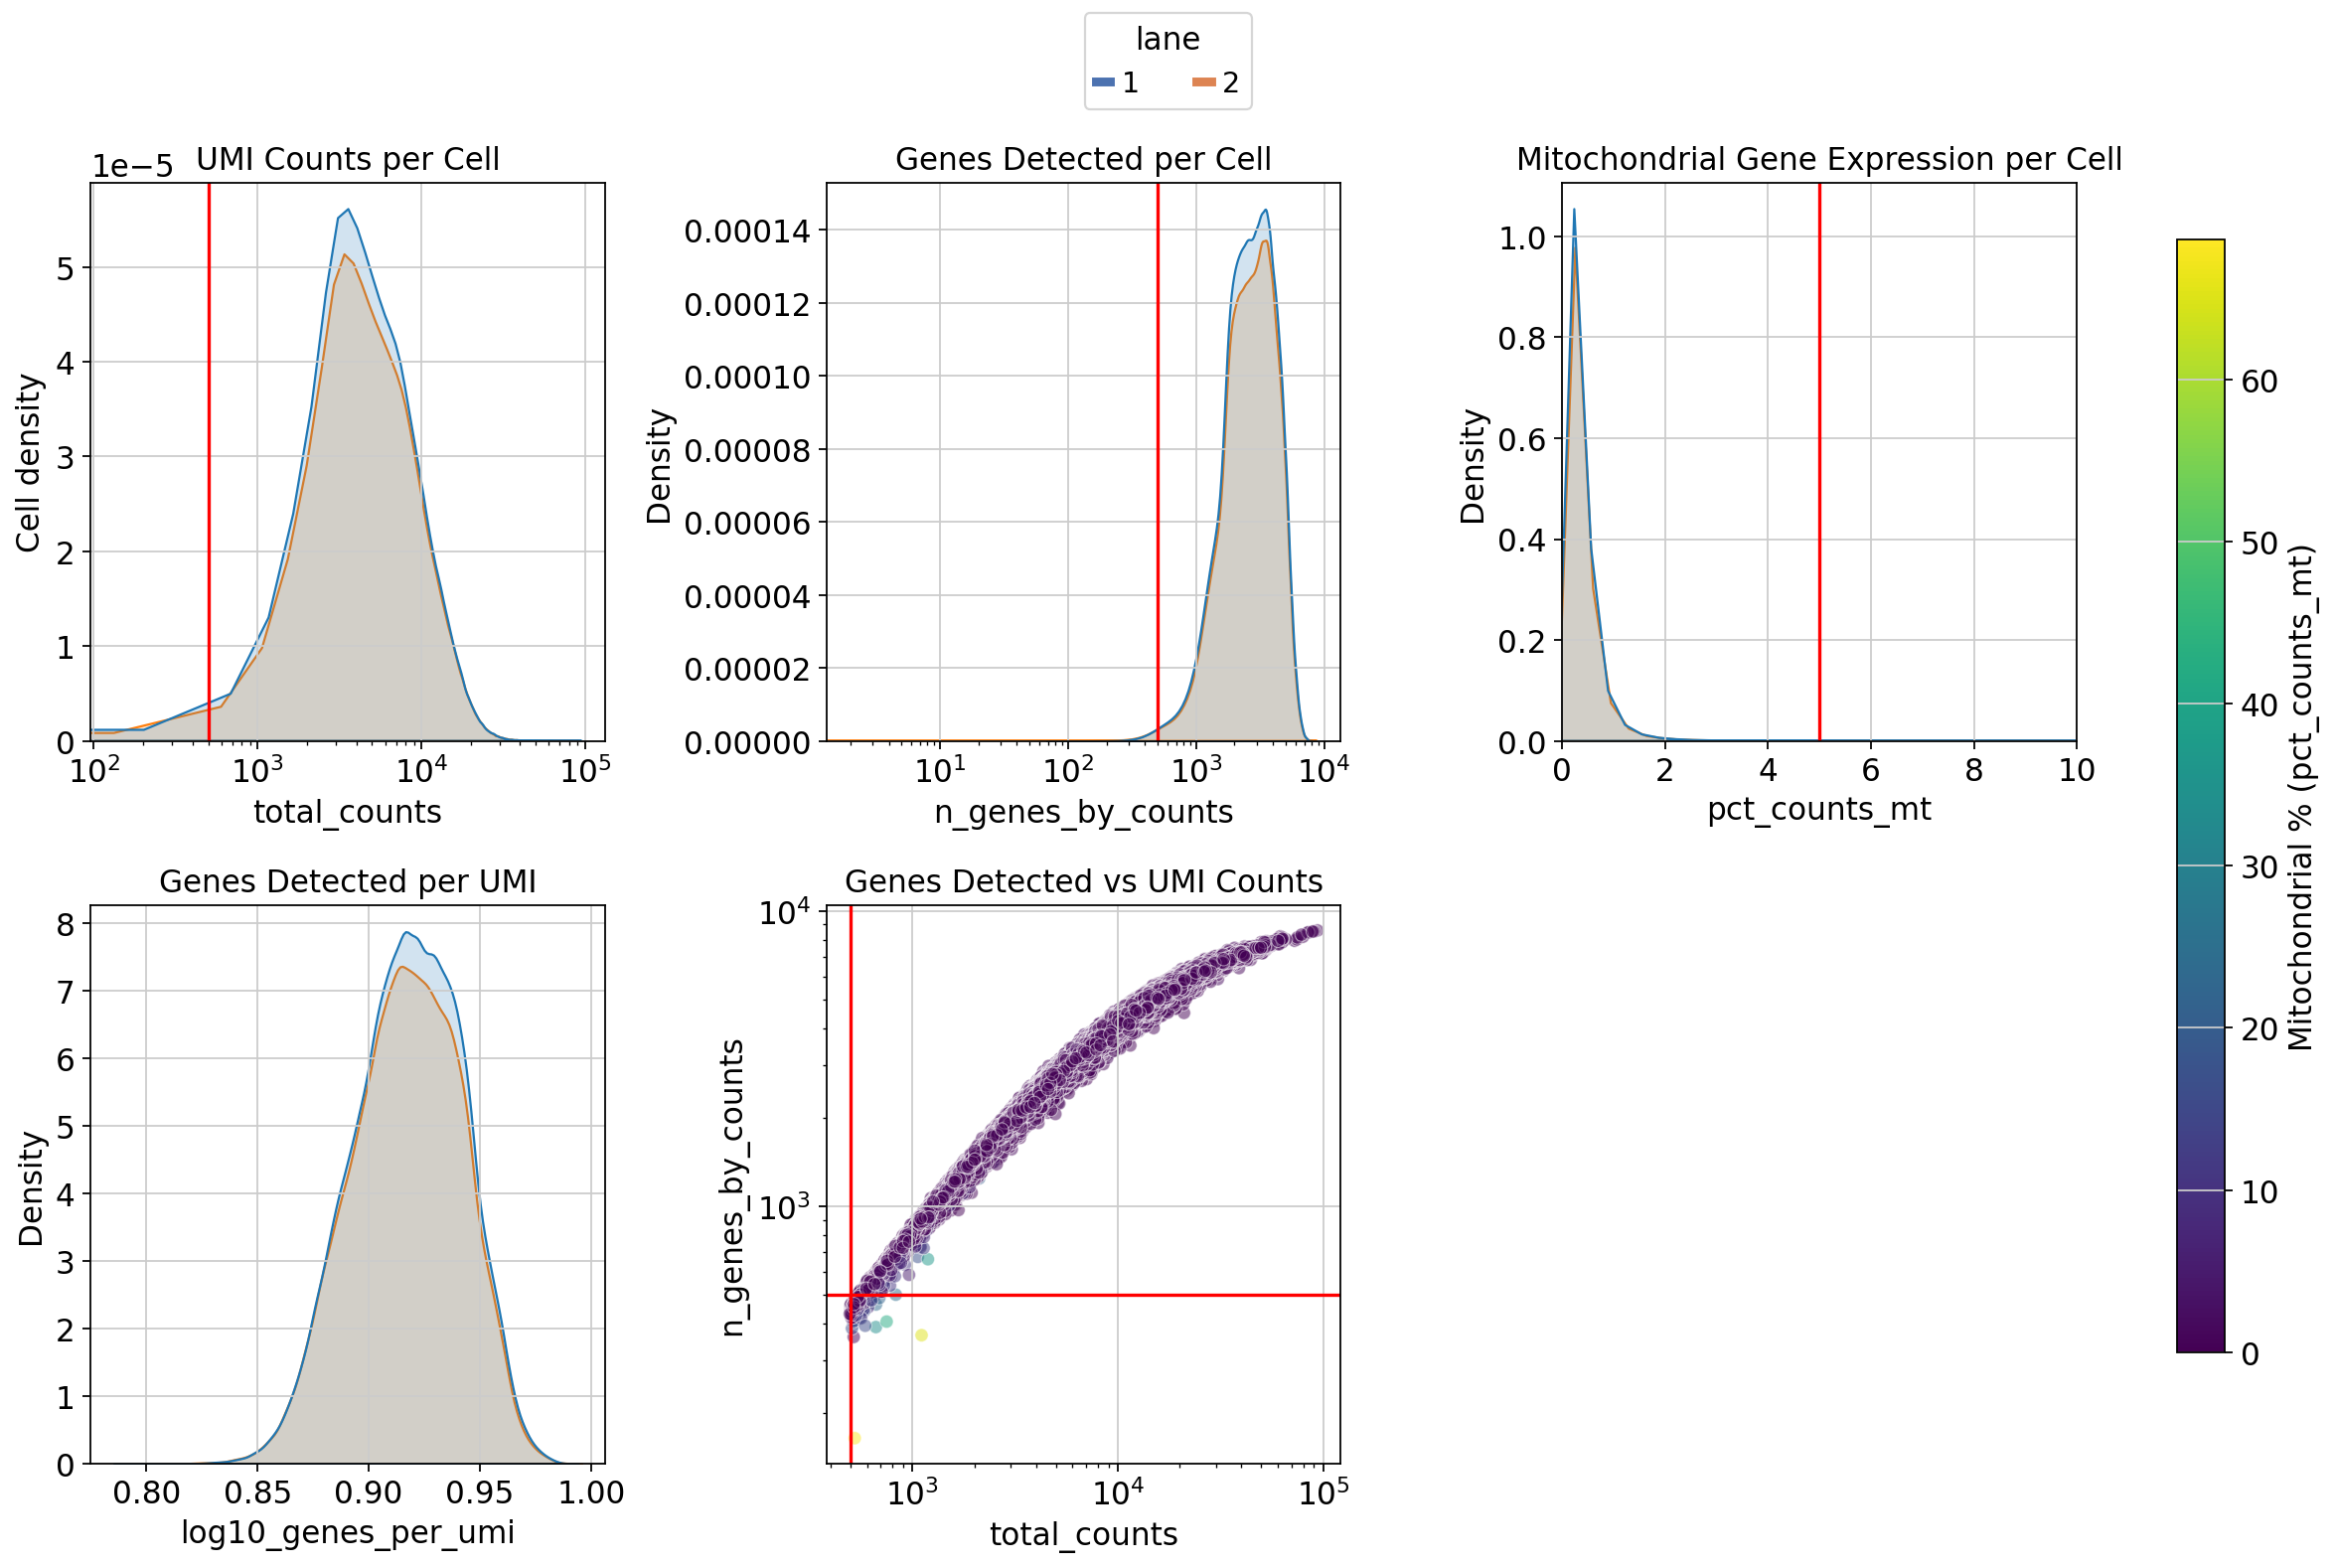

In [51]:
# Example thresholds:
umi_threshold = 500
gene_threshold = 500
mito_threshold = 5
scc.plot_qc_plots(rna, umi_threshold, gene_threshold, mito_threshold, kde_hue="lane", figsize=(15,10))

## Filter by RNA QC Values

In [52]:
# store pre-QC numbers
n_cells_pre = rna.shape[0]

# filter cells by genes, counts, mt genes
mu.pp.filter_obs(rna, 'total_counts', lambda x: x >= umi_threshold)
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: x >= gene_threshold)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < mito_threshold)

In [53]:
# define minimum cells for gene-level filtering
# genes in fraction of perturbation combinations assuming 90% dropout
minCells = rna.shape[0]*(1/800)*0.1
print("Minimum cells required for gene filtering:", minCells)

Minimum cells required for gene filtering: 78.53050000000002


In [54]:
# gene level filtering
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= minCells)

# match obs
mu.pp.intersect_obs(mdata)
mdata.pull_obs()

# get post-QC numbers
n_cells_post = rna.shape[0]

/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [55]:
print("Pre-QC cell #:", n_cells_pre)
print("Post-QC cell #:", n_cells_post)

Pre-QC cell #: 628715
Post-QC cell #: 628244


In [56]:
# Calculate post-QC RNA metrics
rna_qc, qc_metrics = sc.pp.calculate_qc_metrics(rna, qc_vars=["mt", "ribo"], inplace=False, log1p=True)
numeric_metrics = rna_qc.select_dtypes(include="number")
column_means = numeric_metrics.mean()
print("Mean of each QC metric:")
print(column_means)

Mean of each QC metric:
n_genes_by_counts              3375.103791
log1p_n_genes_by_counts           8.048751
total_counts                   8128.993652
log1p_total_counts                8.794178
pct_counts_in_top_50_genes       12.778113
pct_counts_in_top_100_genes      18.678473
pct_counts_in_top_200_genes      27.202468
pct_counts_in_top_500_genes      44.189764
total_counts_mt                  31.737778
log1p_total_counts_mt             3.056036
pct_counts_mt                     0.393545
total_counts_ribo                 0.000000
log1p_total_counts_ribo           0.000000
pct_counts_ribo                   0.000000
dtype: float64


# BC Processing

Here, we will evaluate the barcode expression and identify cells with correct barcode calls.

## BC QC

In [57]:
# Calculate the total bc counts
rna.obs['total_counts_bc'] = bc.layers['counts'].sum(axis=1).A1
# Calculate the log1p of the total bc counts
rna.obs['log1p_total_counts_bc'] = np.log1p(rna.obs['total_counts_bc'])
mdata.pull_obs()

Text(0.5, 1.0, 'bc UMI Counts per Cell')

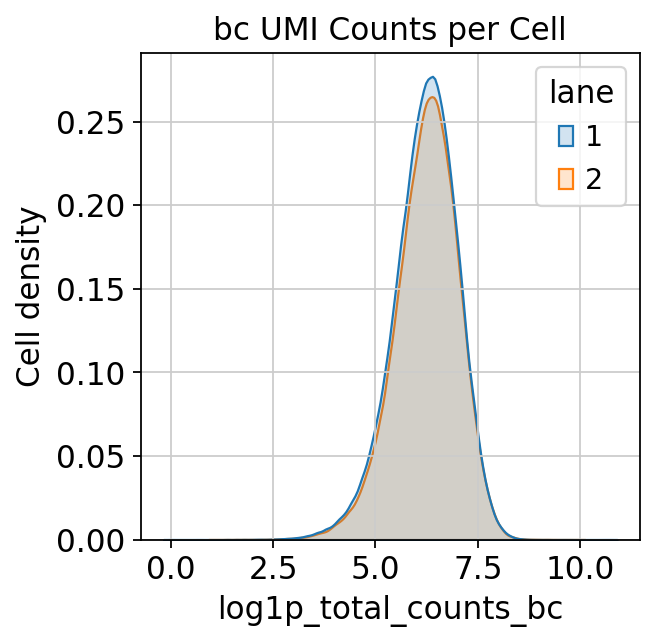

In [58]:
# plot bc UMI count density
p = sns.kdeplot(data=rna.obs, x='log1p_total_counts_bc',
            fill=True, alpha=0.2, hue='lane')
p.set_ylabel("Cell density")
p.set_title("bc UMI Counts per Cell")

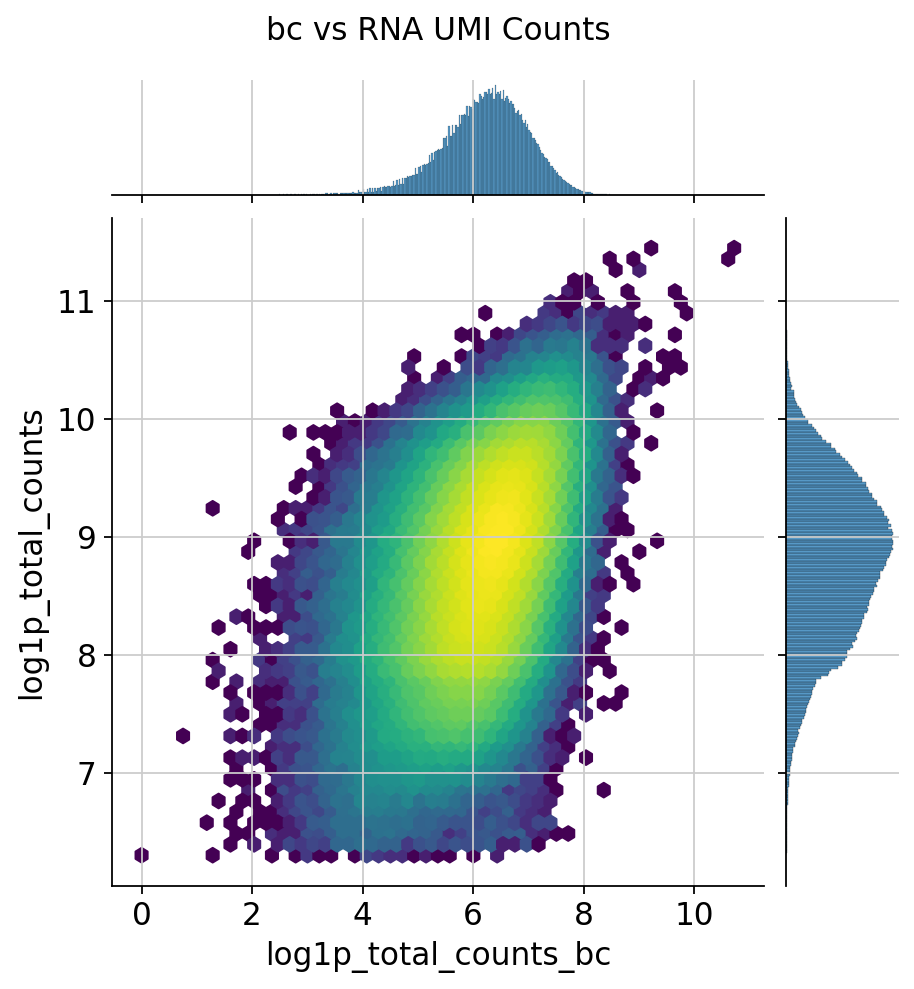

In [59]:
# Plot correlation between bc and RNA UMI for each sample
g = sns.jointplot(
    data=rna.obs,
    x='log1p_total_counts_bc',
    y='log1p_total_counts',
    kind="hex",
    norm=mpl.colors.LogNorm(),
    cmap="viridis",
)
g.ax_joint.set_title("bc vs RNA UMI Counts", pad=80)  # Adjust pad to move the title closer or further
plt.show()

## BC DSB normalization QC

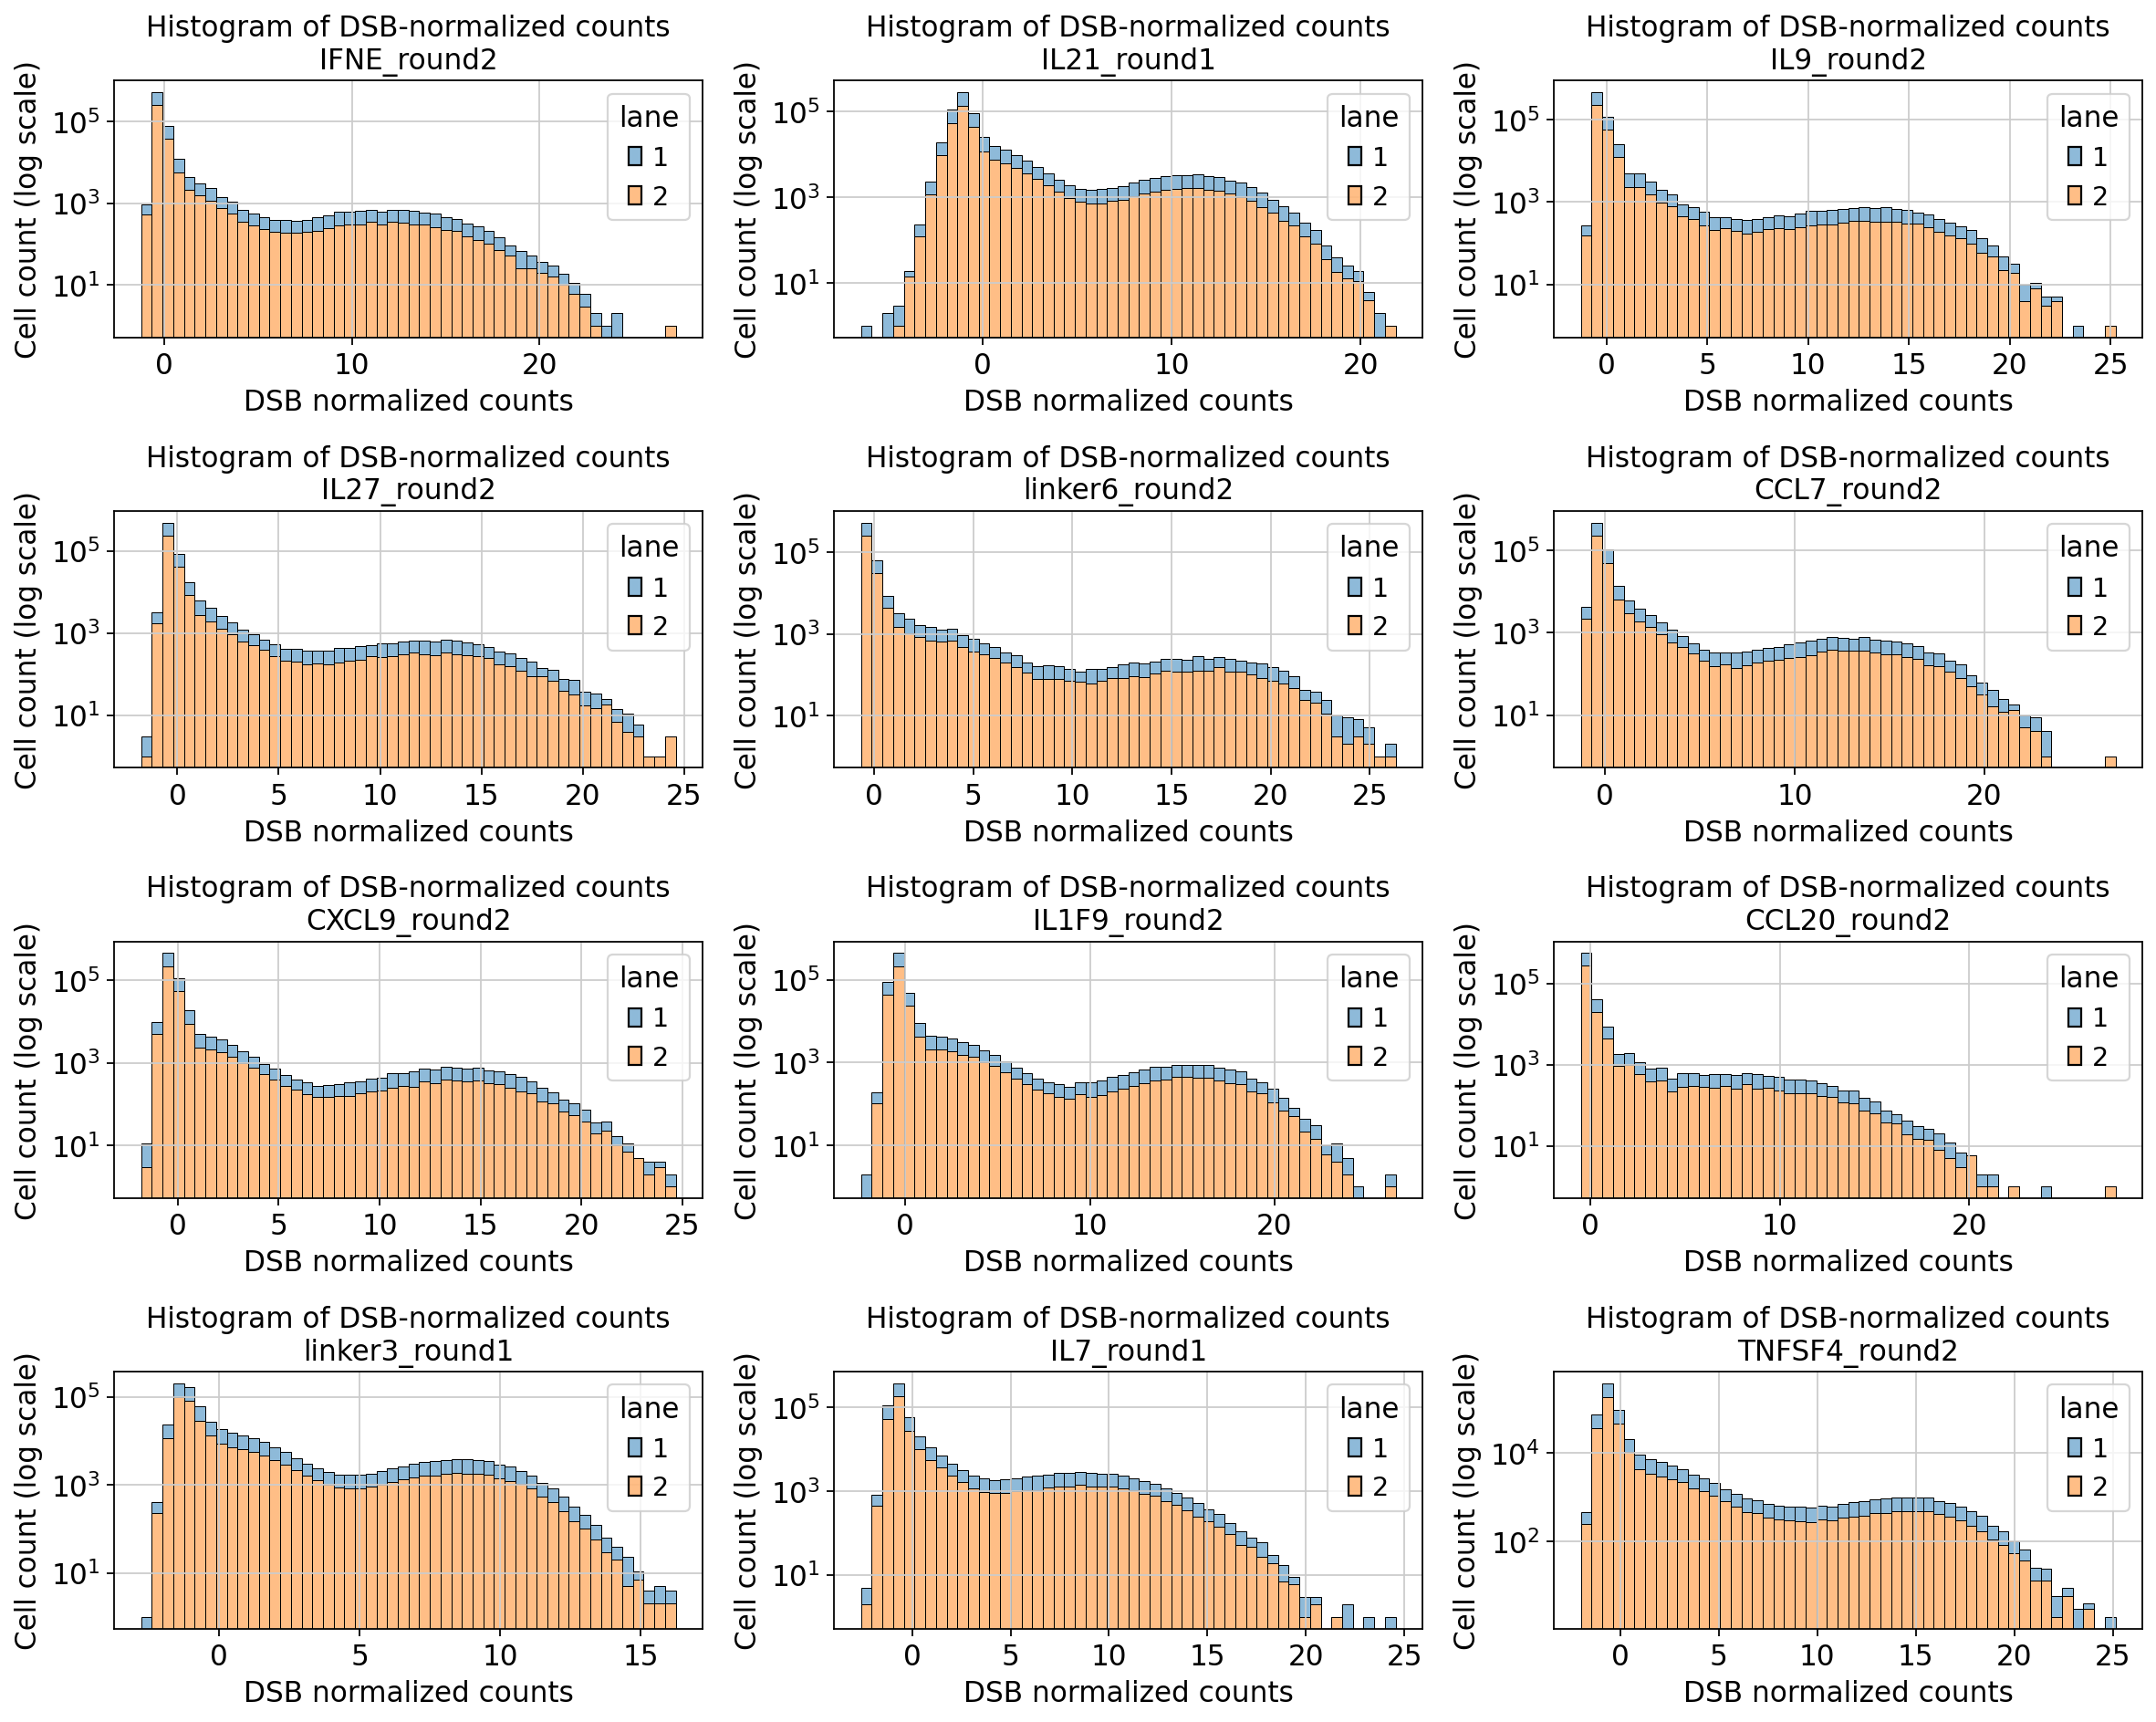

In [60]:
# Add lane information to the DataFrame
bc_df['lane'] = [cell.split('-')[-1] for cell in bc_df.index]

# Select 9 random features
features = np.random.choice(bc_df.columns[:-1], size=12, replace=False)  # Exclude 'lane' column

# Set up 3×3 figure
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
for ax, feat in zip(axes.flatten(), features):
    sns.histplot(data=bc_df, x=feat, bins=50, hue='lane', kde=False, ax=ax, multiple="stack", alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel('DSB normalized counts')
    ax.set_ylabel("Cell count (log scale)")
    ax.set_title(f"Histogram of DSB-normalized counts\n{feat}")

plt.tight_layout()
plt.show()


## Call Cells based on DSB counts and CellRanger Calls

We will "call" cells for ligands based on simple thresholds of DSB normalized counts and cellranger calls (treating barcodes as CRISPR protospacers and using cellrangers calling algorithm).


In [61]:
def generate_feature_calls(adata, umi_threshold=2):
    """
    Generate feature calls for each cell in the AnnData object based on UMI counts.

    Parameters:
    - adata: AnnData object with cells in .obs and features in .var
    - umi_threshold: int, the minimum UMI count to call a feature for a cell (default is 2)

    Returns:
    - A DataFrame with columns: cell_barcode, num_features, num_umis, feature_call
    """
    X = adata.X
    # Handle both sparse and dense matrices
    if hasattr(X, "tocoo"):
        # Sparse matrix
        non_zero_entries = X >= umi_threshold
        rows, cols = non_zero_entries.nonzero()
        umi_counts = X[rows, cols].A1
    else:
        # Dense matrix (numpy ndarray)
        non_zero_entries = X >= umi_threshold
        rows, cols = non_zero_entries.nonzero()
        umi_counts = X[rows, cols]

    # Map rows and columns to cell and feature names
    cell_ids = adata.obs.index[rows]
    feature_names = adata.var.index[cols]

    # Create a DataFrame of these results to group by cell
    data = pd.DataFrame({
        'cell_barcode': cell_ids,
        'feature_name': feature_names,
        'umi_count': umi_counts
    })

    # Group by cell and aggregate features and UMIs
    grouped_data = data.groupby('cell_barcode').agg({
        'feature_name': lambda x: "|".join(x),
        'umi_count': lambda x: "|".join(map(str, x))
    }).reset_index()

    # Add the number of features column
    grouped_data['num_features'] = grouped_data['feature_name'].str.count(r'\|') + 1

    # Rename columns to match desired output
    grouped_data = grouped_data.rename(columns={
        'feature_name': 'feature_call',
        'umi_count': 'num_umis'
    })

    return grouped_data

In [62]:
# get threshold calls from data
callsDSB5 = generate_feature_calls(bc, umi_threshold=5)
callsDSB7 = generate_feature_calls(bc, umi_threshold=7)
callsDSB10 = generate_feature_calls(bc, umi_threshold=10)

In [63]:
# import and concatenate cellranger calls
import os
lane_dir_pattern = "/data1/rudenska/EYW/SIG13/SIG13_lane{}/SIG13_lane{}_GEX_oBC"
protospacer_calls_list = []
for i in [1, 2]:
    # Build the file path for lane i and read the protospacer calls per cell CSV
    lane_dir = lane_dir_pattern.format(i, i)
    protospacer_calls_rep1 = os.path.join(lane_dir, "outs", "per_sample_outs", "SIG13_rep1", "count", "crispr_analysis", "protospacer_calls_per_cell.csv")
    protospacer_calls_rep2 = os.path.join(lane_dir, "outs", "per_sample_outs", "SIG13_rep2", "count", "crispr_analysis", "protospacer_calls_per_cell.csv")
    
    # Import rep1 and rep2 protospacer calls
    calls_rep1 = pd.read_csv(protospacer_calls_rep1)
    calls_rep2 = pd.read_csv(protospacer_calls_rep2)
    
    # Append lane information to the cell barcodes
    calls_rep1['cell_barcode'] = (
        calls_rep1['cell_barcode']
        .where(calls_rep1['cell_barcode'].notna())
        .astype(str)
        .str.split('-', n=1).str[0]
        + f"-{i}"
    )
    calls_rep2['cell_barcode'] = (
        calls_rep2['cell_barcode']
        .where(calls_rep2['cell_barcode'].notna())
        .astype(str)
        .str.split('-', n=1).str[0]
        + f"-{i}"
    )
    
    # Append to the list
    protospacer_calls_list.extend([calls_rep1, calls_rep2])

# Concatenate all protospacer calls into a single DataFrame
callsCr = pd.concat(protospacer_calls_list, axis=0)

# remove cells not in RNA (only applicable to cellranger calls)
callsCr = callsCr[callsCr['cell_barcode'].isin(bc.obs.index)]

## Removing Singlets, Multiplets, and Incorrect Double Calls based on "Round"

In this experiment, ligands from Set A (Round1) were always paired with ligands from Set B (Round2). Thus any cell that is called for ligands belonging to the same "round" is either incorrectly called or a undetected multiplet. I will add a metadata column to filter for these.

In [64]:
# add a column for the "rounds" that the ligands belong to
# this information can be used to filter out impossible doublets
# (e.g. those that should be due to incorrect colling or multiplets as they shouldn't  be possible
# with the experiment treatment layout)
def process_feature_call(df, feature_call_col='feature_call'):
    # Fill NaNs early and create mask for NaNs
    feature_calls = df[feature_call_col].fillna('')
    split_calls = feature_calls.str.split('|')

    # Initialize outputs
    num_unique_groups = []
    ligand_calls = []
    group_calls = []

    for calls in split_calls:
        if calls == ['']:
            num_unique_groups.append(0)
            ligand_calls.append('')
            group_calls.append('')
        else:
            ligands = [c.rsplit('_', 1)[0] for c in calls]
            groups = [c.rsplit('_', 1)[-1] for c in calls]
            ligand_calls.append('_'.join(ligands))
            group_calls.append('_'.join(sorted(groups)))

    df['ligand_call'] = ligand_calls
    df['group_call'] = group_calls

    return df

In [65]:
# add group information to define correct doublets
callsDSB5 = process_feature_call(callsDSB5.copy())
callsDSB7 = process_feature_call(callsDSB7.copy())
callsDSB10 = process_feature_call(callsDSB10.copy())
callsCr = process_feature_call(callsCr.copy())

In [66]:
# Compute summary stats for each set of calls
call_sets = {
    "callsDSB5": callsDSB5,
    "callsDSB7": callsDSB7,
    "callsDSB10": callsDSB10,
    "callsCr": callsCr
}

summary_df = pd.DataFrame({
    name: {
        "total_cells": rna.shape[0],
        "total_cells_with_calls": len(df),
        "singlet_percent": (df["num_features"] == 1).mean() * 100,
        "doublet_percent": (df["num_features"] == 2).mean() * 100,
        "correct_doublet_percent": ((df["num_features"] == 2) & (df['group_call'] == "round1_round2")).mean() * 100,
        "multiplet_percent": (df["num_features"] > 2).mean() * 100,
        "singlet_count": (df["num_features"] == 1).sum(),
        "doublet_count": (df["num_features"] == 2).sum(),
        "correct_doublet_count": ((df["num_features"] == 2) & (df['group_call'] == "round1_round2")).sum(),
        "multiplet_count": (df["num_features"] > 2).sum(),
    }
    for name, df in call_sets.items()
}).T

summary_df

,total_cells,total_cells_with_calls,singlet_percent,doublet_percent,correct_doublet_percent,multiplet_percent,singlet_count,doublet_count,correct_doublet_count,multiplet_count
callsDSB5,628244.0,614800.0,10.254717,61.678595,60.091737,28.066688,63046.0,379200.0,369444.0,172554.0
callsDSB7,628244.0,592869.0,23.586155,61.115187,59.016410,15.298658,139835.0,362333.0,349890.0,90701.0
callsDSB10,628244.0,511980.0,56.270557,37.075276,33.070042,6.654166,288094.0,189818.0,169312.0,34068.0
callsCr,628244.0,624661.0,2.221365,39.106972,38.395706,58.671664,13876.0,244286.0,239843.0,366499.0


I will add all of the calling to the obs, but we will filter using the DSB7 calls based on manual inspection of the histograms above.

In [67]:
# prepare call DataFrames
callsDSB5['num_features'] = callsDSB5['num_features'].fillna(0)
callsDSB5 = callsDSB5.set_index('cell_barcode')
callsDSB7['num_features'] = callsDSB7['num_features'].fillna(0)
callsDSB7 = callsDSB7.set_index('cell_barcode')
callsDSB10['num_features'] = callsDSB10['num_features'].fillna(0)
callsDSB10 = callsDSB10.set_index('cell_barcode')
callsCr['num_features'] = callsCr['num_features'].fillna(0)
callsCr = callsCr.set_index('cell_barcode')

# merge all calls into one DataFrame, suffixing column names to keep them distinct
calls_all = (
    callsDSB5.add_suffix('_DSB5')
    .join(callsDSB7.add_suffix('_DSB7'), how='outer')
    .join(callsDSB10.add_suffix('_DSB10'), how='outer')
    .join(callsCr.add_suffix('_Cr'), how='outer')
)

In [68]:
# left‐join onto rna.obs (preserving all rna.obs rows)
rna.obs = rna.obs.join(calls_all, how='left')

In [69]:
mdata.pull_obs()

In [70]:
# filter cells by CRISPR singlets
mu.pp.filter_obs(rna, 'num_features_DSB7', lambda x: np.isin(x, [2]))
# filter out impossible doublets
mu.pp.filter_obs(rna, 'group_call_DSB7', lambda x: x == "round1_round2")

## Removing Miscellaneous Incorrect Double Calls
Not all combinations of linker-linker were done in this experiment and the pairing of linkers was dependent on the replicate. Thus, we need to filter out the ones that are inappropriate. Most simply we can just look at the distribution and there is a clear cutoff where the calls are not correct.

Also, protein ligands were not paired with linker6-linker9_round2.


<Axes: xlabel='n_cells', ylabel='Count'>

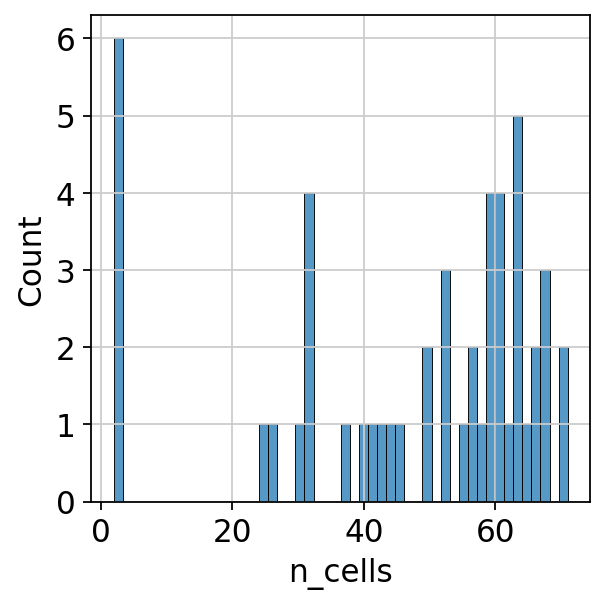

In [71]:
# remove protein ligands paired with linker6-9
# filter out any cell where feature_call_DSB7 follows the regex pattern *_round1|linker[6789]_round2 except when the round 1 assay is linker2 or linker3
calls = rna.obs['feature_call_DSB7'].astype(str)
rna.obs['possible_combination_DSB7'] = ~calls.str.fullmatch(
    r"^(?!linker[23]_round1\|)[^|]+_round1\|linker[6789]_round2$"
)

# define replicate feature calls
rna.obs['replicate_feature_call_DSB7'] = rna.obs['replicate'].astype(str) + "_" + rna.obs['feature_call_DSB7'].astype(str)
rna.obs['replicate_feature_call_DSB7'] = rna.obs['replicate_feature_call_DSB7'].astype('category')

# calculate number of cells for remaining possible combinations
control_num = (rna.obs
               .query('possible_combination_DSB7 == True')
               .groupby(['replicate','feature_call_DSB7','replicate_feature_call_DSB7'], observed=True)
               .size().sort_values(ascending=False)
               .reset_index(name = "n_cells")
               .sort_values(by='n_cells', ascending=True))

# plot histogram of combinations with lowest 50 values
sns.histplot(data=control_num.head(50), x='n_cells', bins=50)

In [72]:
inappropriate_linkers = control_num.query('n_cells < 10')['replicate_feature_call_DSB7'].unique().astype(str)
control_num.head(10)

,replicate,feature_call_DSB7,replicate_feature_call_DSB7,n_cells
1581,rep1,linker3_round1|linker8_round2,rep1_linker3_round1|linker8_round2,2
1580,rep1,linker3_round1|linker9_round2,rep1_linker3_round1|linker9_round2,2
1577,rep2,linker2_round1|linker8_round2,rep2_linker2_round1|linker8_round2,3
1576,rep1,linker3_round1|linker6_round2,rep1_linker3_round1|linker6_round2,3
1579,rep2,linker2_round1|linker6_round2,rep2_linker2_round1|linker6_round2,3
1578,rep2,linker2_round1|linker9_round2,rep2_linker2_round1|linker9_round2,3
1575,rep1,IL6_round1|IFNB1_round2,rep1_IL6_round1|IFNB1_round2,25
1574,rep1,IL23_round1|IL1A_round2,rep1_IL23_round1|IL1A_round2,26
1573,rep1,IL23_round1|IL9_round2,rep1_IL23_round1|IL9_round2,30
1571,rep1,IL23_round1|OSM_round2,rep1_IL23_round1|OSM_round2,31


There's a few combinations that are present but impossible. In replicate 1, linker2_round1 was paired with linker6-9_round2 and in replicate 2, linker3_round1 was paired with linker6-9_round2.

In [73]:
# filter out inappropriate combinations
mu.pp.filter_obs(rna, 'possible_combination_DSB7', lambda x: x == True)
mu.pp.filter_obs(rna, 'replicate_feature_call_DSB7', lambda x: ~x.isin(inappropriate_linkers))
# intersect obs
mu.pp.intersect_obs(mdata)

/home/wange7/miniforge3/envs/scanpy_standard/lib/python3.12/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [75]:
# update categories of feature_call
rna.obs['feature_call_DSB7'] = rna.obs['feature_call_DSB7'].astype(str).astype('category').copy()
mdata.pull_obs()

## Histogram of Feature Calls

/tmp/ipykernel_478848/1125299934.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  callCounts = rna.obs.groupby('feature_call_DSB7').size().reset_index(name='counts').sort_values(by='counts', ascending=False)


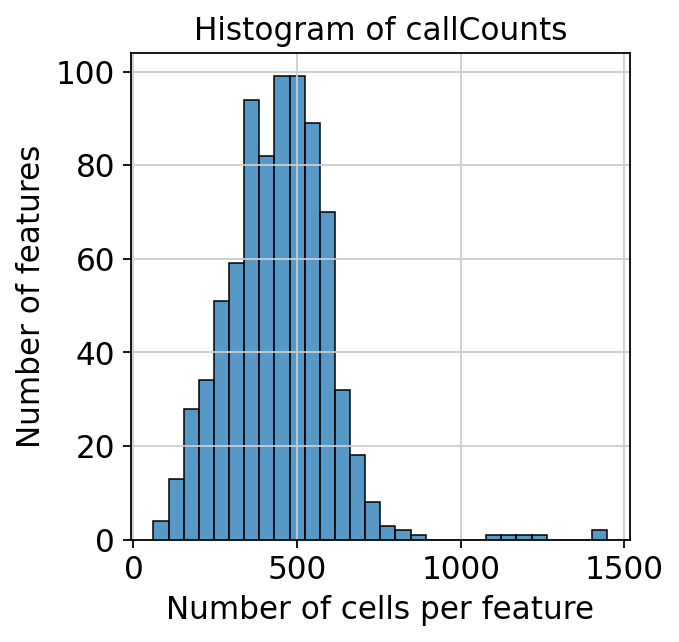

In [76]:
callCounts = rna.obs.groupby('feature_call_DSB7').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

plt.figure(figsize=(4, 4))
sns.histplot(callCounts['counts'], bins=30, kde=False)
plt.xlabel('Number of cells per feature')
plt.ylabel('Number of features')
plt.title('Histogram of callCounts')
plt.show()

# Edit Metadata

In [77]:
# simplify linker names in the existing ligand_call_DSB7 column
rna.obs['ligand_call_DSB7'] = (
    rna.obs['ligand_call_DSB7']
       .str.replace(r'linker[1-9]', 'linker', regex=True)
)

# add round 1 and round 2 columns
rna.obs[['ligand_call_round1_DSB7', 'ligand_call_round2_DSB7']] = (
    rna.obs['ligand_call_DSB7']
       .str.split('_', expand=True)
       .astype('category')
)

# remove possible_combination_DSB7
rna.obs = rna.obs.drop(columns=['possible_combination_DSB7'])

# remove columns that end with _Cr, _DSB5, _DSB10
cols_to_remove = [col for col in rna.obs.columns if col.endswith(('_Cr', '_DSB5', '_DSB10'))]
rna.obs = rna.obs.drop(columns=cols_to_remove)

# Normalize and Add Cell Cycle Scores
I will perform normalization and save them as different layers. Of note, the default scanpy normalization adjusts cells so that all cells have counts = median total counts prior to normalization.

In [78]:
rna.layers['counts'] = rna.X.copy()
rna.layers["norm"] = sc.pp.normalize_total(rna, inplace=False)["X"]
rna.layers["log1p_norm"] = np.log1p(sc.pp.normalize_total(rna, inplace=False)["X"])
# use log1p_norm layer for CC score calculation
rna.X = rna.layers["log1p_norm"].copy()

normalizing counts per cell
    finished (0:00:03)
normalizing counts per cell
    finished (0:00:02)


In [79]:
ccGenes = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/functions/cell_cycle_mouse_cc2019_seurat.csv")

In [80]:
sc.tl.score_genes_cell_cycle(rna,
                             s_genes=ccGenes[ccGenes['phase']=='S'].genes,
                             g2m_genes=ccGenes[ccGenes['phase']=='G2M'].genes,
                             use_raw=False)

calculating cell cycle phase
computing score 'S_score'


    finished: added
    'S_score', score of gene set (adata.obs).
    567 total control genes are used. (0:00:11)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    365 total control genes are used. (0:00:11)
-->     'phase', cell cycle phase (adata.obs)


In [81]:
rna.obs.phase.value_counts()

phase
G2M    141883
G1     122134
S       85702
Name: count, dtype: int64

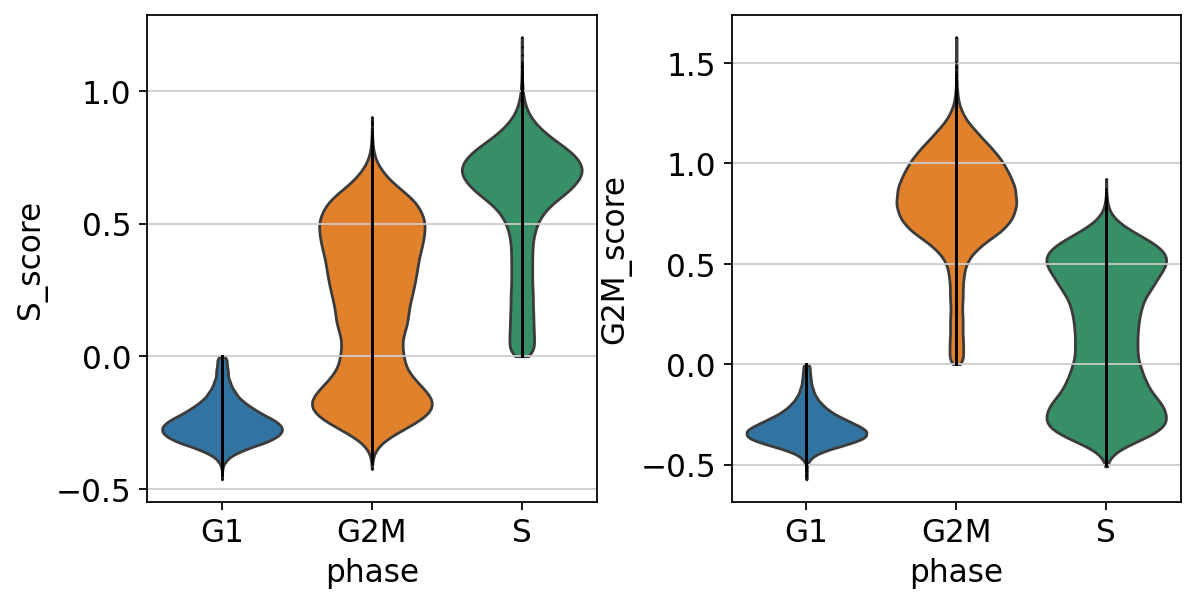

In [82]:
sc.pl.violin(rna, ['S_score', 'G2M_score'],
             jitter=False, groupby = 'phase')

In [83]:
mdata.pull_obs()

# Export Filtered Data

In [7]:
rna.write("/data1/rudenska/EYW/SIG13/scanpy_outs/SIG13_filtered_DSB7.h5ad")